In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [3]:
!pip install torch torchvision matplotlib scikit-learn tensorboard

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Vérifier GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 38.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.11MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.91MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.88MB/s]


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # regularization
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


model = CNN().to(device)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization


In [8]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.1923
Epoch [2/5], Loss: 0.0644
Epoch [3/5], Loss: 0.0450
Epoch [4/5], Loss: 0.0371
Epoch [5/5], Loss: 0.0308


In [9]:
from sklearn.metrics import accuracy_score, f1_score

model.eval()
preds = []
targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        preds.extend(predicted.cpu().numpy())
        targets.extend(labels.numpy())

acc = accuracy_score(targets, preds)
f1 = f1_score(targets, preds, average='macro')

print("Accuracy:", acc)
print("F1-macro:", f1)


Accuracy: 0.9897
F1-macro: 0.9895745178464022


# **Vision Transformer (ViT) minimal**

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np


In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


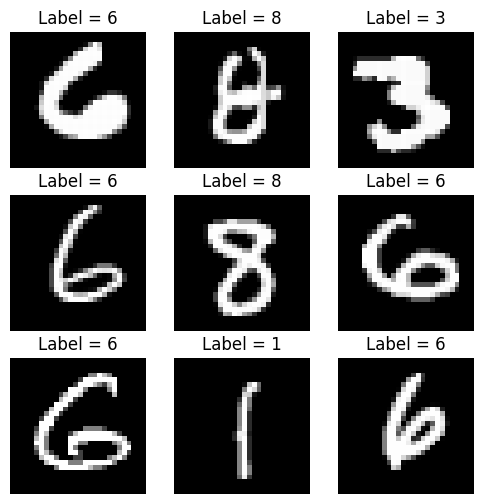

In [13]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Label = {labels[i]}")
    plt.axis("off")
plt.show()


In [14]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=7, embed_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(
            in_channels=1, 
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)      # shape : (B, embed_dim, 4, 4)
        x = x.flatten(2)      # (B, embed_dim, 16)
        x = x.transpose(1,2)  # (B, 16, embed_dim)
        return x


In [15]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, x):
        out, _ = self.attention(x, x, x)
        return out


In [16]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4, mlp_ratio=4):
        super().__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Linear(embed_dim * mlp_ratio, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [17]:
class ViT(nn.Module):
    def __init__(self, 
                 img_size=28, 
                 patch_size=7, 
                 embed_dim=64,
                 num_heads=4,
                 depth=4,
                 num_classes=10):

        super().__init__()

        self.patch_embed = PatchEmbedding(patch_size, embed_dim)

        num_patches = (img_size // patch_size) ** 2

        # Class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Positional encoding
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches+1, embed_dim))

        # Transformer layers
        self.layers = nn.ModuleList([
            TransformerEncoder(embed_dim, num_heads) for _ in range(depth)
        ])

        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)

        # Add class token
        cls_tokens = self.cls_token.expand(B, 1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional encoding
        x = x + self.pos_embed

        # Pass through transformer layers
        for layer in self.layers:
            x = layer(x)

        cls_output = x[:, 0]   # take CLS token
        out = self.fc(cls_output)
        return out


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [19]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss = {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss = 0.3523
Epoch [2/5], Loss = 0.1236
Epoch [3/5], Loss = 0.0915
Epoch [4/5], Loss = 0.0737
Epoch [5/5], Loss = 0.0633


In [20]:
from sklearn.metrics import accuracy_score, f1_score

model.eval()
preds, targets = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        preds.extend(predicted.cpu().numpy())
        targets.extend(labels.numpy())

acc = accuracy_score(targets, preds)
f1 = f1_score(targets, preds, average='macro')

print("ViT Accuracy:", acc)
print("ViT F1-score:", f1)


ViT Accuracy: 0.9757
ViT F1-score: 0.9755586172543455


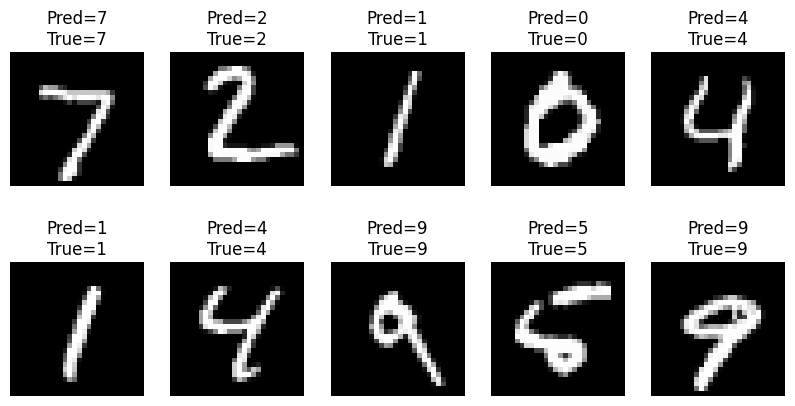

In [21]:
images, labels = next(iter(test_loader))
images_gpu = images.to(device)
outputs = model(images_gpu)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred={predicted[i].item()}\nTrue={labels[i].item()}")
    plt.axis("off")
plt.show()
